# Курсовая работа.
### Корпоративные системы и интеллектуальный анализ данных 2020.
### Выполнил: Макаров Иван

Проверим наличие графического ускорителя Tesla T4, P4, or P100.

In [1]:
!nvidia-smi

Wed May 20 17:04:26 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

Установим RAPIDS на виртуальную машину

In [2]:
# Install RAPIDS
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!bash rapidsai-csp-utils/colab/rapids-colab.sh stable

import sys, os

dist_package_index = sys.path.index('/usr/local/lib/python3.6/dist-packages')
sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.6/site-packages'] + sys.path[dist_package_index:]
sys.path
exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals())

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 103, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 103 (delta 21), reused 14 (delta 1), pack-reused 0
Receiving objects: 100% (103/103), 30.32 KiB | 10.11 MiB/s, done.
Resolving deltas: 100% (21/21), done.
PLEASE READ
********************************************************************************************************
Changes:
1. Now that most people have migrated, we have rem0ved the migration notice.
2. default stable version is now 0.13.  Nightly is now 0.14
3. You can now declare your RAPIDS version as a CLI option and skip the user prompts (ex: '0.13' or '0.14', between 0.11 to 0.14, without the quotes): 
        "!bash rapidsai-csp-utils/colab/rapids-colab.sh <version/label>"
        Examples: '!bash rapidsai-csp-utils/colab/rapids-colab.sh 0.13', or '!bash rapidsai-csp-utils/colab/rapids-colab.sh stable', or '!bash rapidsai-csp-utils/colab

Импортируем необходимые библиотеки

In [0]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab
import seaborn as sns
import cudf

from mpl_toolkits.mplot3d import Axes3D
from google.colab import files
from cudf.io import read_csv
from cuml.preprocessing import LabelEncoder
from cuml.cluster import KMeans

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LinearRegression
from sklearn.metrics import precision_score, recall_score, r2_score as r2s
from cuml.preprocessing import train_test_split
from cuml.linear_model import LinearRegression as cuLR
from cuml.ensemble import RandomForestRegressor, RandomForestClassifier
from cuml.metrics.regression import *
from cuml.metrics.accuracy import accuracy_score

Загрузим необходимые файлы

In [4]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving vehicles.csv to vehicles.csv
User uploaded file "vehicles.csv" with length 17787696 bytes


Импортируем данные


In [5]:
# Файл с различными показателями автомобилей
vehicles_file = 'vehicles.csv'
vehicles_cdf = read_csv(vehicles_file)
print(vehicles_cdf.head())

   barrels08  barrelsA08  charge120  ...  phevCity  phevHwy  phevComb
0  15.695714         0.0        0.0  ...         0        0         0
1  29.964545         0.0        0.0  ...         0        0         0
2  12.207778         0.0        0.0  ...         0        0         0
3  29.964545         0.0        0.0  ...         0        0         0
4  17.347895         0.0        0.0  ...         0        0         0

[5 rows x 83 columns]


In [0]:
print(vehicles_cdf.dtypes)

barrels08     float64
barrelsA08    float64
charge120     float64
charge240     float64
city08          int64
               ...   
modifiedOn     object
startStop      object
phevCity        int64
phevHwy         int64
phevComb        int64
Length: 83, dtype: object


Посмотрим, какие столбцы имеют пропуски и сколько таковых

In [0]:
veh_cols = []
for col in vehicles_cdf.columns:
  if vehicles_cdf[col].isnull().sum() > 0:
    veh_cols.append(col)

print(f'Vehicles columns with nulls:\n{vehicles_cdf.loc[:,veh_cols].isnull().sum()}')

Vehicles columns with nulls:
cylinders       240
displ           238
drive          1189
eng_dscr      16335
trany            11
guzzler       39769
trans_dscr    27206
tCharger      34801
sCharger      41375
atvType       38490
fuelType2     40580
rangeA        40585
evMotor       41243
mfrCode       30818
c240Dscr      42152
c240bDscr     42158
startStop     31704
dtype: int64


### 1.1 Кластеризация

In [0]:
cols_for_clustering = ['barrels08', 'co2TailpipeGpm', 'city08', 'year']
cluster_cdf = vehicles_cdf[cols_for_clustering]
cluster_pdf = cluster_cdf.to_pandas()

          barrels08  co2TailpipeGpm        city08          year
count  42253.000000    42253.000000  42253.000000  42253.000000
mean      17.207654      464.257504     18.513881   2002.021679
std        4.649760      124.388681      8.353888     11.387501
min        0.060000        0.000000      6.000000   1984.000000
25%       14.330870      386.391304     15.000000   1991.000000
50%       16.480500      444.350000     17.000000   2003.000000
75%       19.388824      522.764706     21.000000   2012.000000
max       47.087143     1269.571429    150.000000   2021.000000


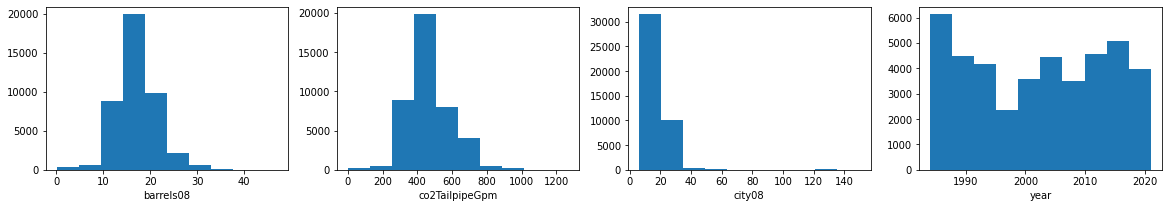

In [0]:
sz = len(cols_for_clustering)
plt.figure(figsize=[20,3])
for i in range(sz):
  plt.subplot(1,sz,i+1)
  plt.hist(cluster_pdf[cols_for_clustering[i]])
  plt.xlabel(cols_for_clustering[i])

print(cluster_cdf.describe())

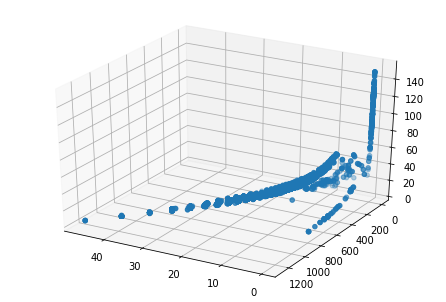

In [0]:
non_cluster_np = np.asarray(cluster_pdf.drop(columns='year')).T

fig = pylab.figure()
axes = Axes3D(fig, azim=120)
axes.scatter(xs=non_cluster_np[0], ys=non_cluster_np[1], zs=non_cluster_np[2])

pylab.show()

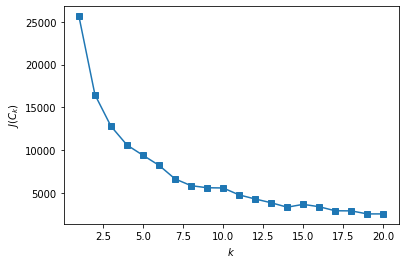

In [73]:
# Выберем число кластеров по правилу "локтя".
# Для этого постороим график зависимости инерции от числа кластеров
inertia = []
for k in range(1, 21):
    kmeans = KMeans(n_clusters=k).fit(cluster_cdf.drop(columns='year'))
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(range(1, 21), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

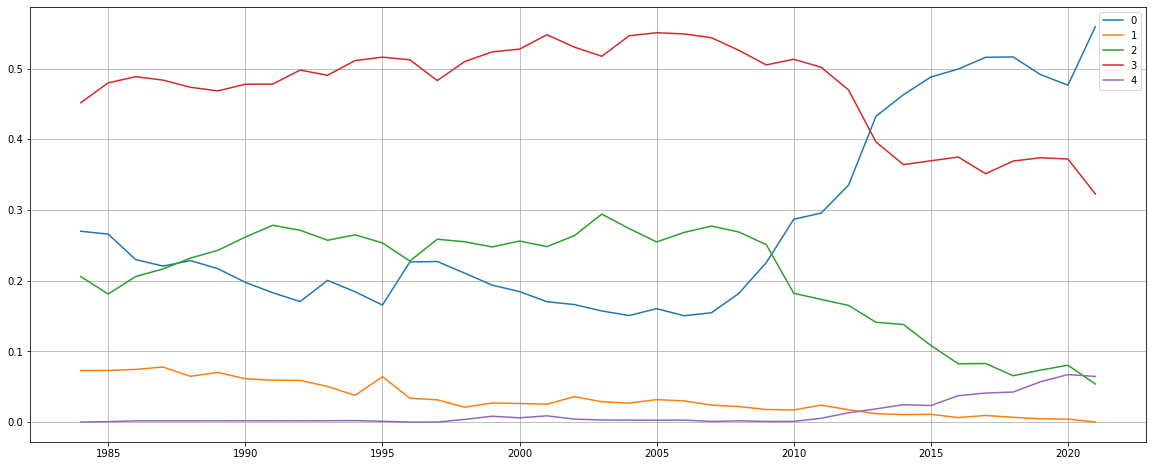

In [12]:
k = 5
kmeans = KMeans(n_clusters=k, n_init=10)
kmeans.fit(cluster_cdf.drop(columns='year'))
cluster_cdf['labels_'] = kmeans.labels_

df = cluster_cdf[['year', 'labels_']].to_pandas()
time_series = np.asarray([[df[(df.year == y) & (df.labels_ == l)]['year'].count()/df[df.year == y]['year'].count() for l in set(df['labels_'])] for y in set(df['year'])])
time_series = time_series.T

lbls = list(set(df['labels_']))
plt.figure(figsize=[20,8])
plt.grid(True)
for i in range(k):
  plt.plot(list(set(df['year'])), time_series[i], label=lbls[i])

plt.legend()

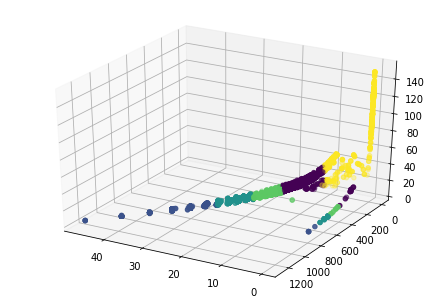

In [13]:
cluster_np = np.asarray(cluster_cdf.drop(columns='year').to_pandas()).T

fig = pylab.figure()
axes = Axes3D(fig, azim=120)
axes.scatter(xs=cluster_np[0], ys=cluster_np[1], zs=cluster_np[2], c=cluster_np[3]/k)

pylab.show()

In [14]:
cluster_cdf['model'] = vehicles_cdf.model
for i in range(k):
  print(cluster_cdf[cluster_cdf['labels_']==i].head())

   barrels08  co2TailpipeGpm  city08  year  labels_    model
2  12.207778      329.148148      23  1985        0  Charger
6  13.184400      355.480000      22  1993        0   Loyale
7  13.733750      370.291667      23  1993        0  Corolla
8  12.677308      341.807692      23  1993        0  Corolla
9  13.184400      355.480000      23  1993        0  Corolla
    barrels08  co2TailpipeGpm  city08  year  labels_                model
1   29.964545      807.909091       9  1985        1           Testarossa
3   29.964545      807.909091      10  1985        1  B150/B250 Wagon 2WD
47  32.961000      888.700000       9  1985        1  B150/B250 Wagon 2WD
58  32.961000      888.700000      10  1985        1       B350 Wagon 2WD
69  32.961000      888.700000      10  1985        1       B350 Wagon 2WD
    barrels08  co2TailpipeGpm  city08  year  labels_                model
14  25.354615      683.615385      12  1985        2  B150/B250 Wagon 2WD
20  20.600625      555.437500      14  199

### 1.2 Классификация

In [0]:
cl_cdf = vehicles_cdf.dropna(axis=1, thresh=30000)
cl_cdf = cl_cdf.dropna()

In [13]:
for col in vehicles_cdf.columns:
  if np.isin(vehicles_cdf[col].dtype, 'int'):
    if vehicles_cdf[vehicles_cdf[col]<0][col].count()>0:
      print(col)

co2
co2A
feScore
ghgScore
ghgScoreA
youSaveSpend


In [0]:
cols_to_drop = ['createdOn', 'modifiedOn', 'mpgData', 'co2', 'co2A', 'ghgScore', 'ghgScoreA', 'youSaveSpend']
categorial_cols = cl_cdf.columns[(cl_cdf.dtypes=='object')].drop(labels=cols_to_drop[:3])
bool_cols = list(cl_cdf.columns[(cl_cdf.dtypes=='bool')])
cols_to_drop.extend(bool_cols)

In [22]:
print(f'Categorial cols:\n{categorial_cols.values}\nBoolean cols:\n{bool_cols}')

Categorial cols:
['drive' 'fuelType' 'fuelType1' 'make' 'model' 'trany' 'VClass']
Boolean cols:
['phevBlended']


In [0]:
le = LabelEncoder()
for col in categorial_cols:
  cl_cdf[col] = le.fit_transform(cl_cdf[col].astype('category'))

cl_cdf.drop(columns=cols_to_drop, inplace=True)
cl_cdf = cl_cdf.dropna()
subset = cl_cdf[cl_cdf.feScore!=-1]

for col in subset.columns:
  subset[col] = subset[col].astype('float32')

In [0]:
X_cl = subset.drop(columns='feScore')
Y_cl = subset.feScore-1

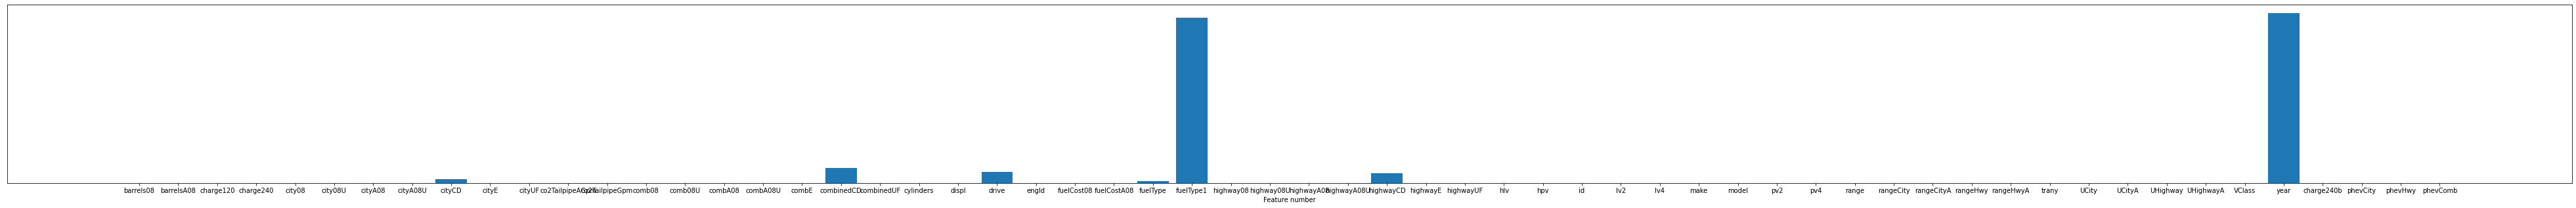

In [11]:
sel= SelectKBest(chi2, k=7)
X_cl_reduced = sel.fit_transform(X_cl.to_pandas(), Y_cl.to_pandas())
X_cl_reduced = pd.DataFrame(data=X_cl_reduced)
X_cl_reduced = cudf.from_pandas(X_cl_reduced)

# Построим столбчатую диаграмму по всем признакам
scores = sel.pvalues_
plt.figure(figsize=[70,5])
plt.bar(X_cl.columns, scores)
plt.xlabel('Feature number')
plt.yticks(())
plt.axis('tight')
plt.show()

In [0]:
class GridSearchCV:

  def __init__(self, estimator, param_grid, cv=None, random_state=0, shuffle=True, refit=True, refit_num=10, convert_dtype=False):
    if param_grid==None or type(param_grid)!=dict:
      raise ValueError('Set param_grid as a dict of parameters with multiple values')
    elif type(param_grid)==dict and len(param_grid)==0:
      raise ValueError('Dictionary param_grid is empty!')
    else:
      for v in param_grid.values():
        if len(v)==1:
          raise ValueError('Each parameter in param_grid must has multiple values!')
    
    self.estimator = estimator
    self.param_grid = param_grid
    self.cv = cv
    self.random_state = random_state
    self.shuffle = shuffle
    self.refit = refit
    self.refit_num = refit_num
    self.convert_dtype = convert_dtype

    self._isfitted = False
    self.fit_scores = None
    self.best_params = None
    self.best_estimator = None


  def fit(self, X, y):

    def get_params_from_grid(param_grid, ids):
      params = {}
      i = 0
      for k,v in param_grid.items():
        try:
          params[k] = v[ids[i]]
        except:
          params[k] = v
        i += 1
      return params

    def new_ids(ids, lim):
      l = len(ids)-1
      if ids[l]<lim[l]:
        ids[l] += 1
      else:
        ids = new(ids[:l], lim[:l])
        ids.append(0)
      return ids

    def train_and_refit(params):
      report = {}
      train_score = []
      test_score = []
      model = self.estimator
      model.set_params(**params)
      for i in range(self.refit_num):
        x1, x2, y1, y2 = train_test_split(X, y,\
                                          train_size=0.8,\
                                          shuffle=self.shuffle,\
                                          random_state=self.random_state)
        model.fit(x1, y1, convert_dtype=self.convert_dtype)
        train_score.append(model.score(x1, y1))
        test_score.append(model.score(x2, y2))

      train_score = np.asarray(train_score)
      test_score = np.asarray(test_score)
      report['train_score'] = train_score.mean()
      report['test_score'] = test_score.mean()
      return report

    def simple_train_test(params):
      report = {}
      x1, x2, y1, y2 = train_test_split(X, y,\
                                        train_size=0.8,\
                                        shuffle=self.shuffle,\
                                        random_state=self.random_state)
      model = self.estimator
      model.set_params(**params)
      model.fit(x1, y1, convert_dtype=self.convert_dtype)
      report['train_score'] = model.score(x1, y1)
      report['test_score'] = model.score(x2, y2)
      return report

    def cross_validation(params):
      return None

    def train_test(params):
      if self.cv == None:
        if self.refit == True:
          results = train_and_refit(params)
        else:
          results = simple_train_test(params)
      elif self.cv <= 1:
        raise ValueError('CV value must be higher than 1!')
      elif int(self.cv) != self.cv:
        raise ValueError('CV value must be integer!')
      else:
        results = cross_validation(params)
      return results

    def recur(param_grid, ids=None):
      if ids == None:
        ids = [0 for i in range(len(param_grid.keys()))]

      lim = [len(v)-1 for v in param_grid.values()]
      if ids==lim:
        return [train_test(get_params_from_grid(param_grid, ids))]
      else:
        vec = [train_test(get_params_from_grid(param_grid, ids))]
        ids = new_ids(ids, lim)
        vec.extend(recur(param_grid, ids))
        return vec

    def shape_scores(scores):
      prepared_scores = {}
      for k,v in scores[0].items():
        prepared_scores[k] = [d[k] for d in scores]
      return prepared_scores

    def get_best_params(fit_scores):
      param_grid = self.param_grid
      shape_ = [len(v) for v in param_grid.values()]
      reshaped_fit_scores = np.array(fit_scores['test_score']).reshape(shape_)
      try:
        metric = self.estimator.accuracy_metric
      except:
        metric = ''
      if ('mse' in metric) or ('mae' in metric):
        ids_ = np.where(reshaped_fit_scores==reshaped_fit_scores.min())
      else:
        ids_ = np.where(reshaped_fit_scores==reshaped_fit_scores.max())
      ids_ = [i[0] for i in ids_]
      
      best_params = {}
      i = 0
      for k,v in param_grid.items():
        best_params[k] = v[ids_[i]]
        i += 1
      return best_params

    def get_best_estimator(best_params):
      x1, x2, y1, y2 = train_test_split(X, y,\
                                        train_size=0.8,\
                                        shuffle=self.shuffle,\
                                        random_state=self.random_state)
      model = self.estimator
      model.set_params(**best_params)
      model.fit(x1, y1, convert_dtype=self.convert_dtype)
      return model

    scores = recur(self.param_grid)
    self.fit_scores = shape_scores(scores)
    self.best_params = get_best_params(self.fit_scores)
    self.best_estimator = get_best_estimator(self.best_params)
    self._isfitted = True

Best parameters:  {'n_estimators': 75}
Best parameters:  {'max_depth': 11}
Random Forest Classifier accuracy: 0.556


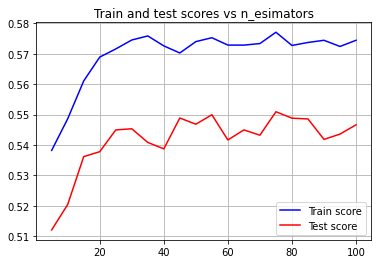

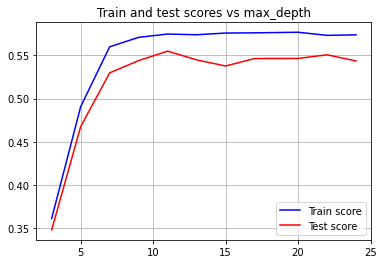

In [13]:
# Сформируем тренировочные и тестовые наборы из датасета с пониженной размерностью
X_train, X_test, Y_train, Y_test = train_test_split(X_cl_reduced, Y_cl, test_size=0.2, random_state=7)

# Инициализируем нашу модель
rfc = RandomForestClassifier(seed=10)

# Зададим набор значений числа базовых моделей n_estimators
rng = range(5,105,5)
forest_params = {'n_estimators': rng}

# Инициализируем и проведём поиск лучшего числа базовых деревьев
forest_grid = GridSearchCV(estimator=rfc, param_grid=forest_params, random_state=5, convert_dtype=True)
forest_grid.fit(X_train, Y_train)
rfc = forest_grid.best_estimator

# Выведем результаты обучения и тестирования
train_score = forest_grid.fit_scores['train_score']
test_score = forest_grid.fit_scores['test_score']
x = rng

plt.figure()
plt.plot(x, train_score, "b", label='Train score')
plt.plot(x, test_score, "r", label='Test score')
ttl = 'Train and test scores vs n_esimators'
plt.title(ttl)
plt.legend()
plt.grid(True)

print('Best parameters: ', forest_grid.best_params)

# Повторим эксперимент, зафиксируем число базовых моделей n_estimators
# и зададим значения глубины дерева max_depth
rng =  [3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24]
forest_params = {'max_depth': rng}

# Инициализируем и проведём поиск лучшего значения максимальной глубины дерева
forest_grid = GridSearchCV(estimator=rfc, param_grid=forest_params, random_state=5, convert_dtype=True)
forest_grid.fit(X_train, Y_train)
rfc = forest_grid.best_estimator

# Выведем результаты обучения и тестирования
train_score = forest_grid.fit_scores['train_score']
test_score = forest_grid.fit_scores['test_score']
x = rng

plt.figure()
plt.plot(x, train_score, "b", label='Train score')
plt.plot(x, test_score, "r", label='Test score')
ttl = 'Train and test scores vs max_depth'
plt.title(ttl)
plt.legend()
plt.grid(True)

print('Best parameters: ', forest_grid.best_params)

# Оценим качество полученной модели:
rfc_accuracy = accuracy_score(Y_test, rfc.predict(X_test))
print('Random Forest Classifier accuracy: %.3f' % rfc_accuracy)

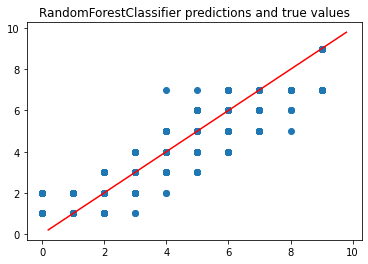

In [19]:
rfc_predict = rfc.predict(X_test).to_pandas()
y_true = Y_test.to_pandas()

plt.scatter(x=y_true, y=rfc_predict)
lim1 = min(rfc_predict)
lim2 = max(rfc_predict)
ran = lim2 - lim1
plt.plot([lim1-0.1*ran, lim2+0.1*ran], [lim1-0.1*ran, lim2+0.1*ran], 'r-')
plt.title('RandomForestClassifier predictions and true values');

In [23]:
rfc_precision = precision_score(y_true, rfc_predict, average='weighted')
rfc_recall = recall_score(y_true, rfc_predict, average='weighted')

print('Random Forest Classifier precision score: %.3f' % rfc_precision,
      '\nRandom Forest Classifier recall score: %.3f' % rfc_recall)

Random Forest Classifier precision score: 0.532 
Random Forest Classifier recall score: 0.556


### 1.3 Регрессия

In [0]:
feature_cols = ['city08', 'highway08', 'comb08', 'cityA08', 'highwayA08', 'combA08', 'displ', 'cylinders']
target_col = 'youSaveSpend'

reg_cdf = vehicles_cdf[[*feature_cols,target_col]]
reg_cdf = reg_cdf.dropna()

In [37]:
reg_cdf.corr()

city08  highway08    comb08  ...     displ  cylinders  youSaveSpend
city08        1.000000   0.922825  0.985826  ... -0.723111  -0.686331      0.777115
highway08     0.922825   1.000000  0.968639  ... -0.709939  -0.647180      0.759676
comb08        0.985826   0.968639  1.000000  ... -0.734694  -0.687593      0.788917
cityA08       0.150106   0.083560  0.123229  ... -0.010558  -0.011035      0.079505
highwayA08    0.124340   0.069768  0.101999  ...  0.010378   0.007913      0.074115
combA08       0.140205   0.078222  0.115068  ... -0.002108  -0.003453      0.077693
displ        -0.723111  -0.709939 -0.734694  ...  1.000000   0.904671     -0.728816
cylinders    -0.686331  -0.647180 -0.687593  ...  0.904671   1.000000     -0.758243
youSaveSpend  0.777115   0.759676  0.788917  ... -0.728816  -0.758243      1.000000

[9 rows x 9 columns]

             city08     highway08  ...     cylinders  youSaveSpend
count  42013.000000  42013.000000  ...  42013.000000  42013.000000
mean      18.032704     24.251303  ...      5.713374  -2903.262086
std        5.049119      5.960877  ...      1.758580   2368.722608
min        6.000000      9.000000  ...      2.000000 -21500.000000
25%       15.000000     20.000000  ...      4.000000  -4250.000000
50%       17.000000     24.000000  ...      6.000000  -2500.000000
75%       21.000000     28.000000  ...      6.000000  -1000.000000
max       58.000000     61.000000  ...     16.000000   2750.000000

[8 rows x 9 columns]


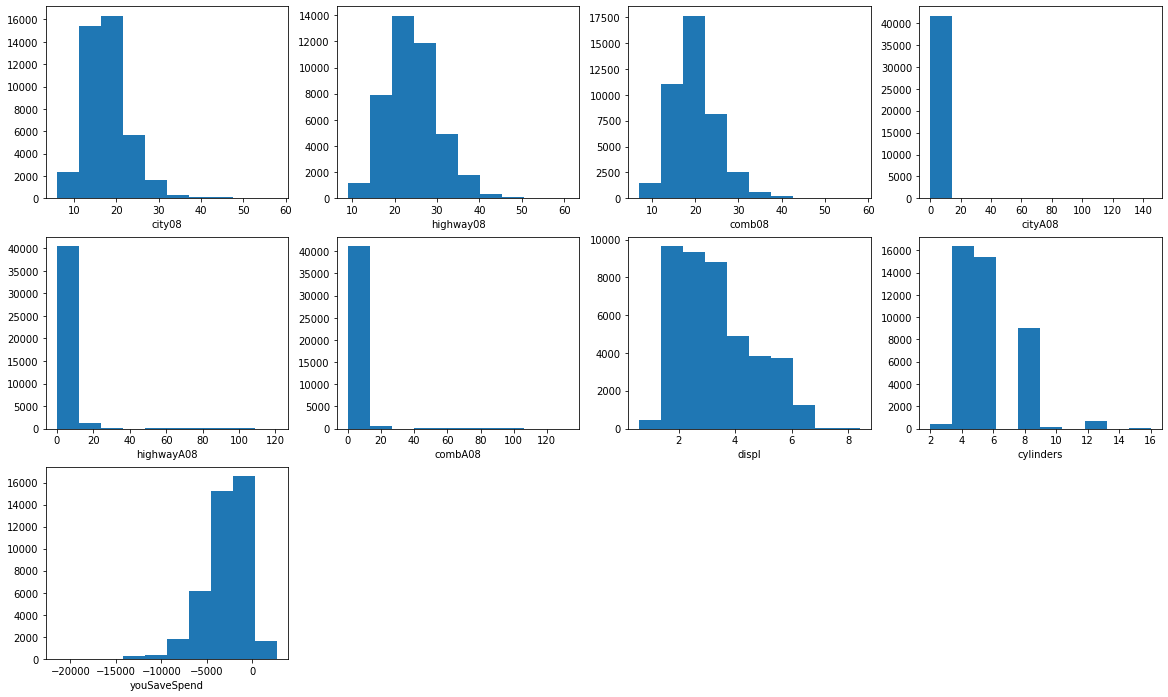

In [25]:
reg_pdf = reg_cdf.to_pandas()
cols_for_regression = list(reg_cdf.columns)
sz = len(cols_for_regression)
plt.figure(figsize=[20,12])
for i in range(sz):
  plt.subplot(sz//4+1,4,i+1)
  plt.hist(reg_pdf[cols_for_regression[i]])
  plt.xlabel(cols_for_regression[i])

print(reg_cdf.describe())

In [0]:
for col in reg_cdf.columns:
  reg_cdf[col] = reg_cdf[col].astype('float32')

In [0]:
X_reg = reg_cdf[['comb08', 'cylinders']]
Y_reg = reg_cdf.youSaveSpend

In [28]:
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X_reg, Y_reg, test_size=0.2, random_state=17)

lr = cuLR(normalize=True)
reg = lr.fit(X1_train, Y1_train)
print(f'Coefficients:\n{reg.coef_}')
print(f'intercept: {reg.intercept_}')
print(f'MSE: {mean_squared_error(Y1_test, reg.predict(X1_test))}')
print(f'MAE: {mean_absolute_error(Y1_test, reg.predict(X1_test))}')

Coefficients:
0    226.720322
1   -554.736328
dtype: float32
intercept: -4339.83544921875
MSE: 1585991.6
MAE: 1004.23663


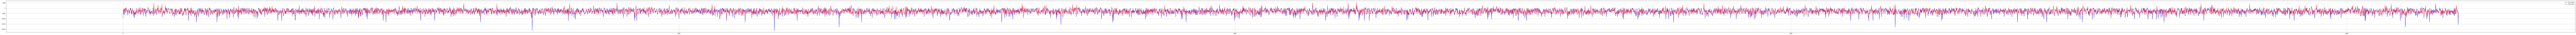

In [58]:
x = range(len(Y1_test))
y_true = Y1_test.to_pandas()
y_pred = reg.predict(X1_test)
plt.figure(figsize=[400,5])
plt.plot(x, y_true, "b", label='True value')
plt.plot(x, y_pred.to_pandas(), "r", label='Pred value')
plt.legend()
plt.grid(True)

Best parameters:  {'n_estimators': 45}
Best parameters:  {'max_depth': 9}
Random Forest Regressor MSE: 1596359.125 
Random Forest Regressor MAE: 1016.586


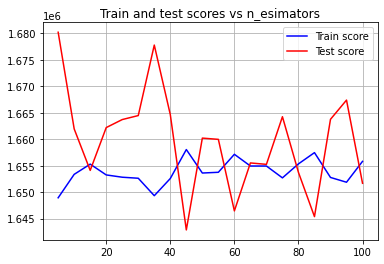

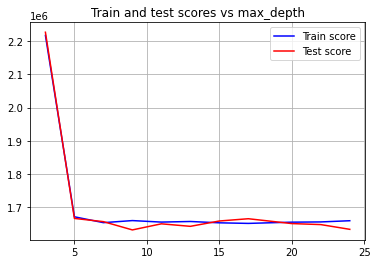

In [29]:
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X_reg, Y_reg, test_size=0.2, random_state=17)

# Инициализируем нашу модель
rfr = RandomForestRegressor(seed=10)

# Зададим набор значений числа базовых моделей n_estimators
rng = range(5,105,5)
forest_params = {'n_estimators': rng}

# Инициализируем и проведём поиск лучшего числа базовых деревьев
forest_grid = GridSearchCV(estimator=rfr, param_grid=forest_params, random_state=5)
forest_grid.fit(X1_train, Y1_train)
rfr = forest_grid.best_estimator

# Выведем результаты обучения и тестирования
train_score = forest_grid.fit_scores['train_score']
test_score = forest_grid.fit_scores['test_score']
x = rng

plt.figure()
plt.plot(x, train_score, "b", label='Train score')
plt.plot(x, test_score, "r", label='Test score')
ttl = 'Train and test scores vs n_esimators'
plt.title(ttl)
plt.legend()
plt.grid(True)

print('Best parameters: ', forest_grid.best_params)

# Повторим эксперимент, зафиксируем число базовых моделей n_estimators
# и зададим значения глубины дерева max_depth
rng =  [3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24]
forest_params = {'max_depth': rng}

# Инициализируем и проведём поиск лучшего значения максимальной глубины дерева
forest_grid = GridSearchCV(estimator=rfr, param_grid=forest_params, random_state=5)
forest_grid.fit(X1_train, Y1_train)
rfr = forest_grid.best_estimator

# Выведем результаты обучения и тестирования
train_score = forest_grid.fit_scores['train_score']
test_score = forest_grid.fit_scores['test_score']
x = rng

plt.figure()
plt.plot(x, train_score, "b", label='Train score')
plt.plot(x, test_score, "r", label='Test score')
ttl = 'Train and test scores vs max_depth'
plt.title(ttl)
plt.legend()
plt.grid(True)

print('Best parameters: ', forest_grid.best_params)

# Оценим качество полученной модели:
rfr_quality = [mean_squared_error(Y1_test, rfr.predict(X1_test)),
               mean_absolute_error(Y1_test, rfr.predict(X1_test))]
print('Random Forest Regressor MSE: %.3f' % rfr_quality[0],
      '\nRandom Forest Regressor MAE: %.3f' %  rfr_quality[1])

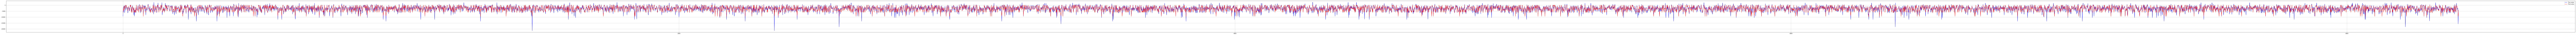

In [53]:
x = range(len(Y1_test))
y_true = Y1_test.to_pandas()
y_pred = rfr.predict(X1_test)
plt.figure(figsize=[400,5])
plt.plot(x, y_true, "b", label='True value')
plt.plot(x, y_pred.to_pandas(), "r", label='Pred value')
plt.legend()
plt.grid(True)

In [30]:
y_true = Y1_test.to_pandas()
lr_pred = reg.predict(X1_test).to_pandas()
forest_pred = rfr.predict(X1_test).to_pandas()
lr_corr = np.corrcoef([y_true, lr_pred])[0][1]
forest_corr = np.corrcoef([y_true, forest_pred])[0][1]
print('Comparation linear regression with forest by correlation coeffs:')
print(f'linreg {lr_corr}')
print(f'forest {forest_corr}')

Comparation linear regression with forest by correlation coeffs:
linreg 0.8432037522318853
forest 0.8409689184403876


In [31]:
print('Linear model R2-score: %.3f' % r2s(y_true, lr_pred),
      '\nRandomForestRegressor R2-score: %.3f' %  r2s(y_true, forest_pred))

Linear model R2-score: 0.711 
RandomForestRegressor R2-score: 0.707


Text(0.5, 1.0, 'Forest predictions and true values')

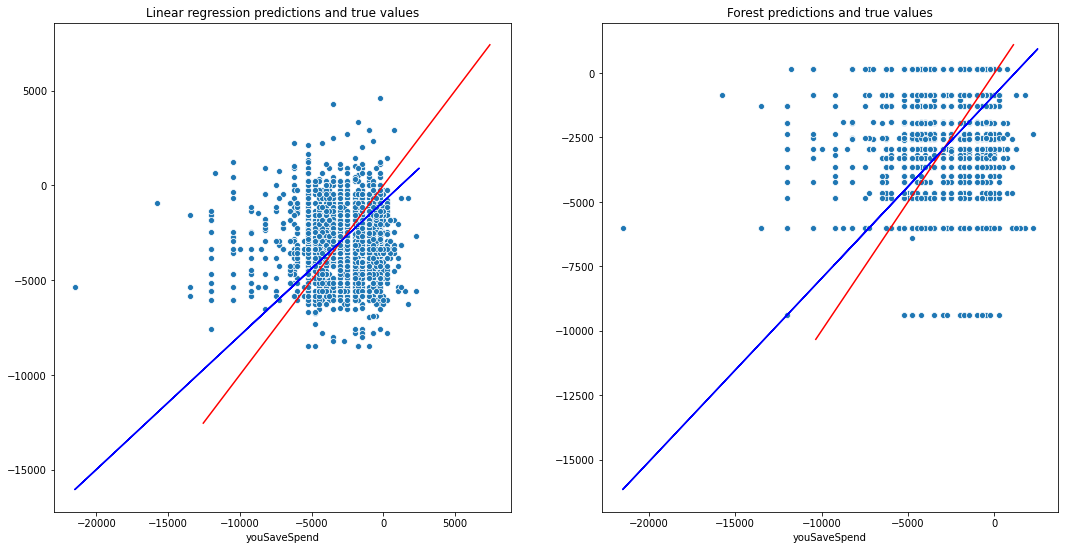

In [57]:
# Построим графики, на оси абсцисс которых расположены истинные значения, а на оси ординат - прогнозные
plt.figure(figsize=(18, 9))
lin = LinearRegression()

plt.subplot(1,2,1)
sns.scatterplot(x=y_true, y=lr_pred)
lim1 = min(lr_pred)
lim2 = max(lr_pred)
ran = lim2 - lim1
plt.plot([lim1-0.1*ran, lim2+0.1*ran], [lim1-0.1*ran, lim2+0.1*ran], 'r-')

X = np.asarray(y_true).reshape(-1,1)
Y = np.asarray(lr_pred).reshape(-1,1)
lin.fit(X, Y)
fact = lin.predict(X)
plt.plot(y_true, fact, 'b-')
plt.title('Linear regression predictions and true values')

plt.subplot(1,2,2)
sns.scatterplot(x=y_true, y=forest_pred)
lim1 = min(forest_pred)
lim2 = max(forest_pred)
ran = lim2 - lim1
plt.plot([lim1-0.1*ran, lim2+0.1*ran], [lim1-0.1*ran, lim2+0.1*ran], 'r-')

X = np.asarray(y_true).reshape(-1,1)
Y = np.asarray(forest_pred).reshape(-1,1)
lin.fit(X, Y)
fact = lin.predict(X)
plt.plot(y_true, fact, 'b-')
plt.title('Forest predictions and true values')